In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [79]:
df = pd.read_csv('../vb_data/agg_stations.csv')

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 4 columns):
update       1006 non-null object
free         1006 non-null int64
available    1006 non-null int64
total        1006 non-null int64
dtypes: int64(3), object(1)
memory usage: 31.5+ KB


In [81]:
df['update'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['update']]

In [82]:
df.set_index('update', inplace = True)

Our season will be comprised of (24*4) observations, since this is quarter hourly data we can see that every cycle seems more or less to happen over one day. This also makes intuitive sense because 96 quarter hours make one day

In [37]:
24*4

96

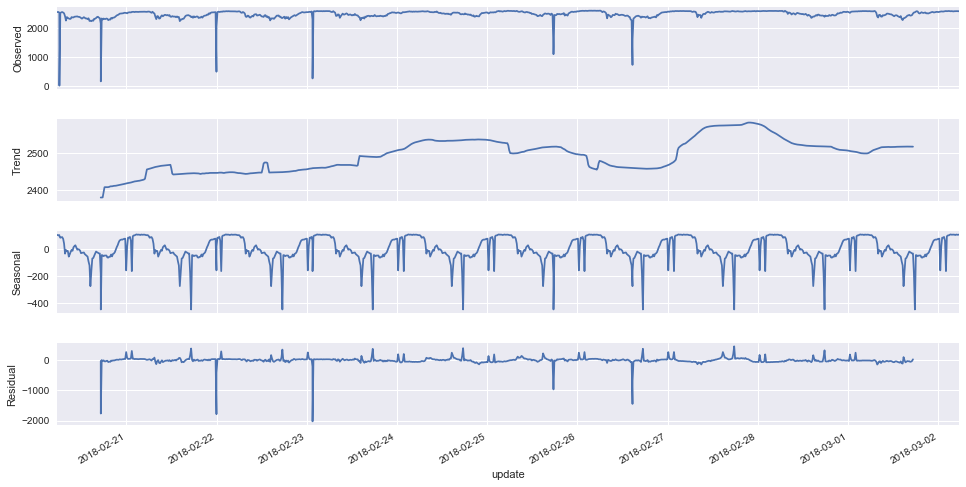

In [38]:
decomposition = seasonal_decompose(df[0:960].available, freq=96)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### Dickey-Fuller: empirical method of evaluating whether we've achieved stationarity.
The null hypothesis is that it is not stationary, the alternative hypothesis is that it is stationary. If we reject our null-hypothesis, then we are saying that our timeseries is already stationary and does not need to be differenced. If we fail to reject it, then our timeseries is not stationary, and does need to be differenced.

In [40]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=96)
    rolstd = pd.rolling_std(timeseries, window=96)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).mean()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).std()


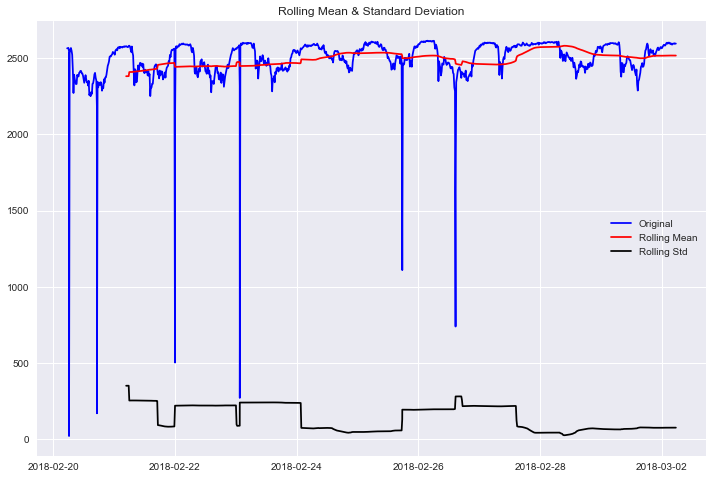

Results of Dickey-Fuller Test:
Test Statistic                -6.448176e+00
p-value                        1.547063e-08
#Lags Used                     8.000000e+00
Number of Observations Used    9.510000e+02
Critical Value (1%)           -3.437245e+00
Critical Value (10%)          -2.568391e+00
Critical Value (5%)           -2.864584e+00
dtype: float64


In [42]:
test_stationarity(df[0:960].available)

/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).mean()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).std()


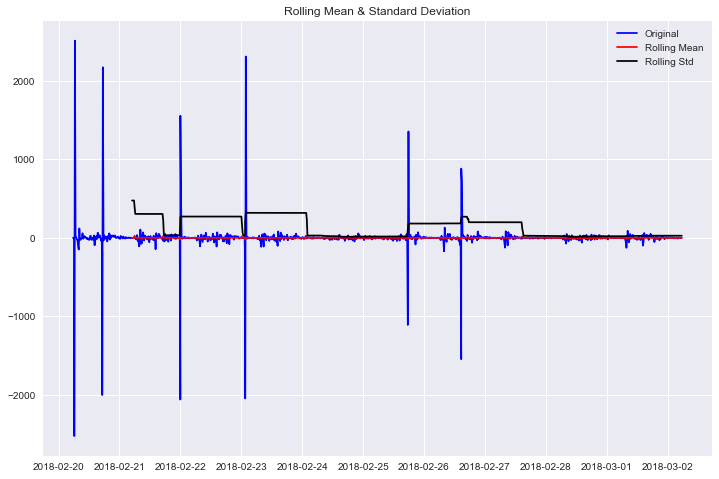

Results of Dickey-Fuller Test:
Test Statistic                -1.309785e+01
p-value                        1.734414e-24
#Lags Used                     1.300000e+01
Number of Observations Used    9.450000e+02
Critical Value (1%)           -3.437289e+00
Critical Value (10%)          -2.568401e+00
Critical Value (5%)           -2.864603e+00
dtype: float64


In [44]:
df['first_difference'] = df[0:960].available - df[0:960].available.shift(1)  
test_stationarity(df.first_difference.dropna(inplace=False))

/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).mean()
/Users/nmolivo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=96,center=False).std()


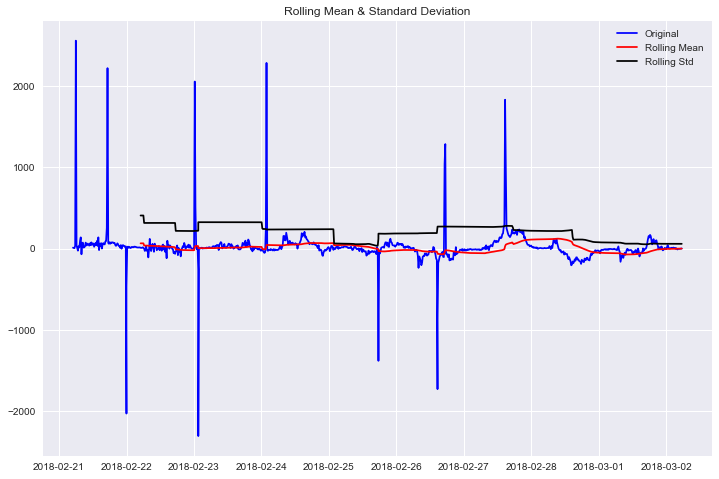

Results of Dickey-Fuller Test:
Test Statistic                -9.302529e+00
p-value                        1.102647e-15
#Lags Used                     6.000000e+00
Number of Observations Used    8.570000e+02
Critical Value (1%)           -3.438003e+00
Critical Value (10%)          -2.568569e+00
Critical Value (5%)           -2.864918e+00
dtype: float64


In [46]:
df['seasonal_difference'] = df[0:960].available - df[0:960].available.shift(96)
test_stationarity(df.seasonal_difference.dropna(inplace=False))

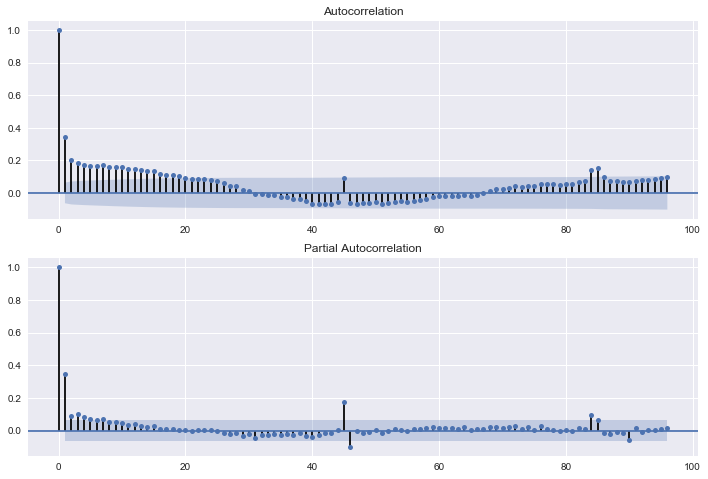

In [47]:
# What we actually want to do is plot the autocorrelation plots of our de-trended, stationary data
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df[0:960].available, lags=96, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df[0:960].available, lags=96, ax=ax2)

In [48]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,0), seasonal_order=(0,1,1,24))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 24)   Log Likelihood               -6216.252
Date:                            Mon, 12 Mar 2018   AIC                          12438.504
Time:                                    00:16:53   BIC                          12453.105
Sample:                                02-20-2018   HQIC                         12444.064
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3333      0.011     30.700      0.000       0.312       0.355
ma.S.L24      -0.8979      0.016    -56.479      0.000      -0.929      -0.867
sigma2      3.244e+04    447.806     72.450      0.000    3.16e+04    3.33e+04
===================================================================================
Ljung-Box (Q):                       91.65   Jarque-Bera (JB):            159029.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -3.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        66.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,0), seasonal_order=(0,1,7,24), enforce_invertibility = False)
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(1, 0, 0)x(0, 1, 7, 24)   Log Likelihood               -6202.174
Date:                            Tue, 13 Mar 2018   AIC                          12422.348
Time:                                    13:03:41   BIC                          12466.150
Sample:                                02-20-2018   HQIC                         12439.028
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3109      0.011     27.056      0.000       0.288       0.333
ma.S.L24      -0.8459      0.017    -49.417      0.000      -0.879      -0.812
ma.S.L48      -0.0981      0.017     -5.632      0.000      -0.132      -0.064
ma.S.L72       0.0648      0.018      3.546      0.000       0.029       0.101
ma.S.L96      -0.0156      0.023     -0.689      0.491      -0.060       0.029
ma.S.L120     -0.0456      0.032     -1.419      0.156      -0.109       0.017
ma.S.L144     -0.0541      0.045     -1.215      0.224      -0.141       0.033
ma.S.L168      0.1613      0.024      6.714      0.000       0.114       0.208
sigma2      3.146e+04    364.051     86.422      0.000    3.07e+04    3.22e+04
===================================================================================
Ljung-Box (Q):                       76.12   Jarque-Bera (JB):            156228.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -3.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        65.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
len(df)

1006

In [91]:
df['forecast'] =results.predict(start = 900, end= 1006, dynamic=True)

In [95]:
predictions = pd.DataFrame(results.predict(start = 900, end= 1006, dynamic=True))

In [97]:
predictions.columns = ["forecast"]

In [101]:
data = df.reset_index()

In [104]:
data.drop('forecast', axis =1, inplace = True)

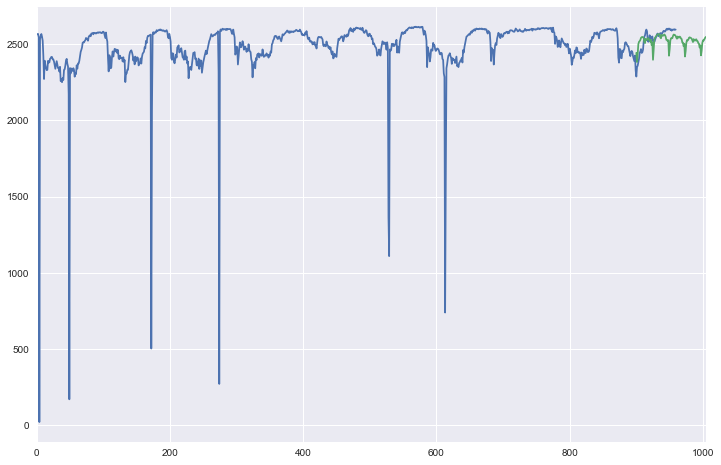

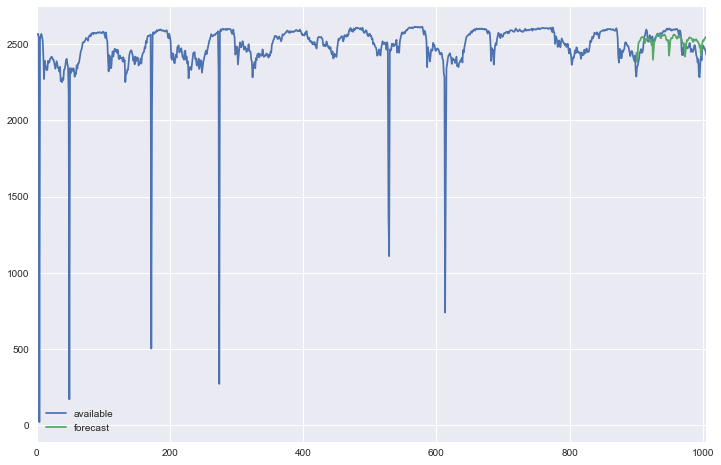

In [105]:
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 
#plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [154]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(4,0,4), seasonal_order=(1,0,7,24),enforce_stationarity =False, enforce_invertibility = False)
results = mod.fit()
results.summary()

/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(4, 0, 4)x(1, 0, 7, 24)   Log Likelihood               -4993.923
Date:                            Tue, 13 Mar 2018   AIC                          10021.845
Time:                                    14:10:42   BIC                          10104.583
Sample:                                02-20-2018   HQIC                         10053.354
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5183      0.029     17.719      0.000       0.461       0.576
ar.L2         -0.0555      0.052     -1.073      0.283      -0.157       0.046
ar.L3          0.5853      0.043     13.554      0.000       0.501       0.670
ar.L4         -0.0480      0.035     -1.361      0.174      -0.117       0.021
ma.L1         -0.0042      0.031     -0.132      0.895      -0.066       0.057
ma.L2          0.0526      0.056      0.936      0.349      -0.057       0.163
ma.L3         -0.4925      0.051     -9.633      0.000      -0.593      -0.392
ma.L4         -0.1349      0.043     -3.120      0.002      -0.220      -0.050
ar.S.L24       0.1320      0.109      1.213      0.225      -0.081       0.345
ma.S.L24      -0.1488      0.135     -1.105      0.269      -0.413       0.115
ma.S.L48       0.0738      0.071      1.039      0.299      -0.065       0.213
ma.S.L72      -0.0074      0.205     -0.036      0.971      -0.410       0.395
ma.S.L96      -0.0287      0.062     -0.462      0.644      -0.150       0.093
ma.S.L120      0.0318      0.115      0.275      0.783      -0.194       0.258
ma.S.L144      0.0429      0.092      0.469      0.639      -0.137       0.222
ma.S.L168      0.0379      0.123      0.309      0.757      -0.203       0.279
sigma2      2.428e+04    574.938     42.236      0.000    2.32e+04    2.54e+04
===================================================================================
Ljung-Box (Q):                       17.74   Jarque-Bera (JB):            510450.72
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -6.52
Prob(H) (two-sided):                  0.00   Kurtosis:                       127.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
predictions = pd.DataFrame(results.predict(start = 900, end= 1006, dynamic=True))
predictions.columns = ["forecast"]
data = df.reset_index()

In [156]:
data.drop('forecast', axis =1, inplace=True)

In [157]:
data = data.join(predictions)

In [158]:
data.head()

,update,free,available,total,forecast
0,2018-02-20 05:27:07,2822,2564,5437,NaN
1,2018-02-20 05:41:52,2821,2565,5437,NaN
2,2018-02-20 05:56:30,2819,2567,5437,NaN
3,2018-02-20 06:11:17,2742,2545,5337,NaN
4,2018-02-20 06:12:18,77,22,100,NaN


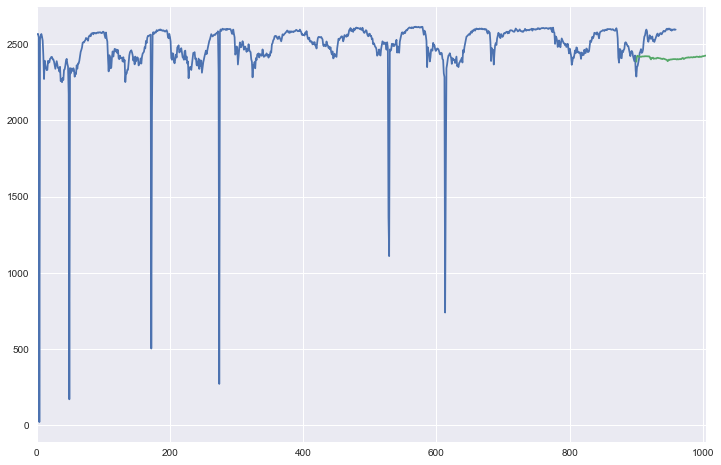

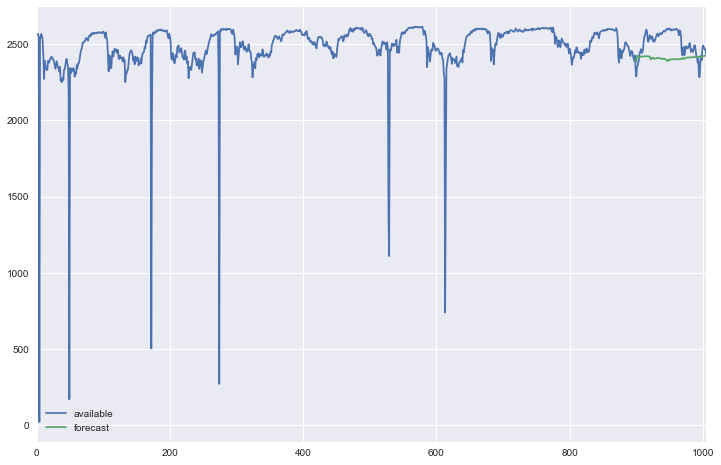

In [159]:
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 
#plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [163]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(1,0,1), seasonal_order=(4,0,7,24),enforce_stationarity =False, enforce_invertibility = False)
results = mod.fit()
results.summary()

/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(1, 0, 1)x(4, 0, 7, 24)   Log Likelihood               -5119.394
Date:                            Tue, 13 Mar 2018   AIC                          10266.789
Time:                                    14:41:50   BIC                          10334.926
Sample:                                02-20-2018   HQIC                         10292.737
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3883      0.133      2.922      0.003       0.128       0.649
ma.L1          0.0011      0.136      0.008      0.993      -0.266       0.268
ar.S.L24       0.3495      0.252      1.385      0.166      -0.145       0.844
ar.S.L48      -0.1250      0.180     -0.695      0.487      -0.478       0.228
ar.S.L72       0.2563      0.240      1.070      0.285      -0.213       0.726
ar.S.L96       0.5220      0.271      1.923      0.054      -0.010       1.054
ma.S.L24      -0.2833      0.253     -1.119      0.263      -0.780       0.213
ma.S.L48       0.1472      0.191      0.769      0.442      -0.228       0.522
ma.S.L72      -0.1789      0.272     -0.658      0.510      -0.712       0.354
ma.S.L96      -0.4762      0.273     -1.744      0.081      -1.011       0.059
ma.S.L120     -0.0210      0.066     -0.317      0.751      -0.151       0.109
ma.S.L144     -0.0155      0.134     -0.115      0.908      -0.279       0.248
ma.S.L168      0.0391      0.067      0.587      0.557      -0.091       0.169
sigma2      3.727e+04   1744.661     21.361      0.000    3.38e+04    4.07e+04
===================================================================================
Ljung-Box (Q):                       36.65   Jarque-Bera (JB):            412175.44
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -8.42
Prob(H) (two-sided):                  0.00   Kurtosis:                       113.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [164]:
predictions = pd.DataFrame(results.predict(start = 900, end= 1006, dynamic=True))
predictions.columns = ["forecast"]
data = df.reset_index()
data.drop('forecast', axis =1, inplace=True)
data = data.join(predictions)

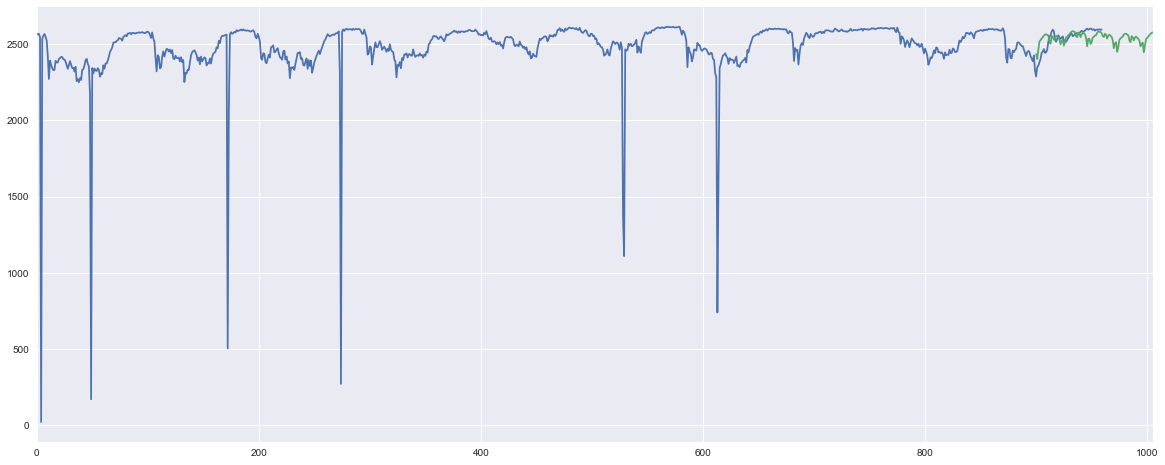

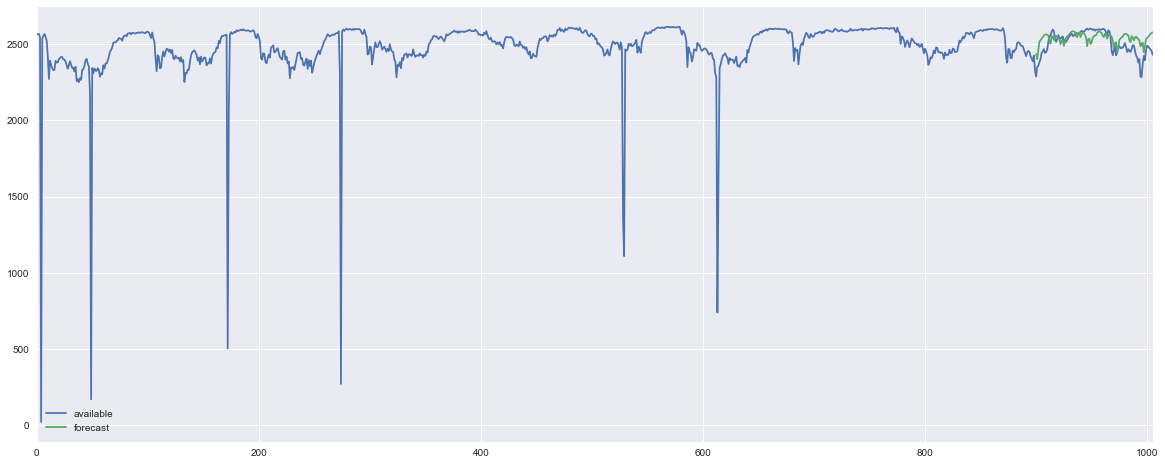

In [165]:
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 
#plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [166]:
mod = sm.tsa.statespace.SARIMAX(df[0:960].available, trend='n', order=(4,0,0), seasonal_order=(4,0,7,24), enforce_invertibility = False)
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          available   No. Observations:                  960
Model:             SARIMAX(4, 0, 0)x(4, 0, 7, 24)   Log Likelihood               -6369.390
Date:                            Tue, 13 Mar 2018   AIC                          12770.780
Time:                                    15:13:18   BIC                          12848.651
Sample:                                02-20-2018   HQIC                         12800.435
                                     - 03-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4362      0.009     47.861      0.000       0.418       0.454
ar.L2          0.1527      0.015     10.275      0.000       0.124       0.182
ar.L3          0.2011      0.015     13.008      0.000       0.171       0.231
ar.L4          0.2087      0.014     15.011      0.000       0.181       0.236
ar.S.L24       0.1826      0.314      0.582      0.561      -0.433       0.798
ar.S.L48       0.1266      0.240      0.526      0.599      -0.345       0.598
ar.S.L72       0.2439      0.257      0.949      0.343      -0.260       0.748
ar.S.L96       0.4445      0.294      1.510      0.131      -0.133       1.022
ma.S.L24      -0.1620      0.321     -0.504      0.614      -0.792       0.468
ma.S.L48      -0.1375      0.339     -0.406      0.685      -0.802       0.527
ma.S.L72      -0.2316      0.278     -0.833      0.405      -0.777       0.314
ma.S.L96      -0.4638      0.326     -1.421      0.155      -1.103       0.176
ma.S.L120     -0.1153      0.058     -1.998      0.046      -0.228      -0.002
ma.S.L144     -0.0638      0.055     -1.150      0.250      -0.173       0.045
ma.S.L168      0.1910      0.080      2.399      0.016       0.035       0.347
sigma2      3.509e+04   6288.657      5.580      0.000    2.28e+04    4.74e+04
===================================================================================
Ljung-Box (Q):                       64.17   Jarque-Bera (JB):            310258.41
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -6.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        90.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.11e+14. Standard errors may be unstable.
"""

In [167]:
predictions = pd.DataFrame(results.predict(start = 900, end= 1006, dynamic=True))
predictions.columns = ["forecast"]
data = df.reset_index()
data.drop('forecast', axis =1, inplace=True)
data = data.join(predictions)

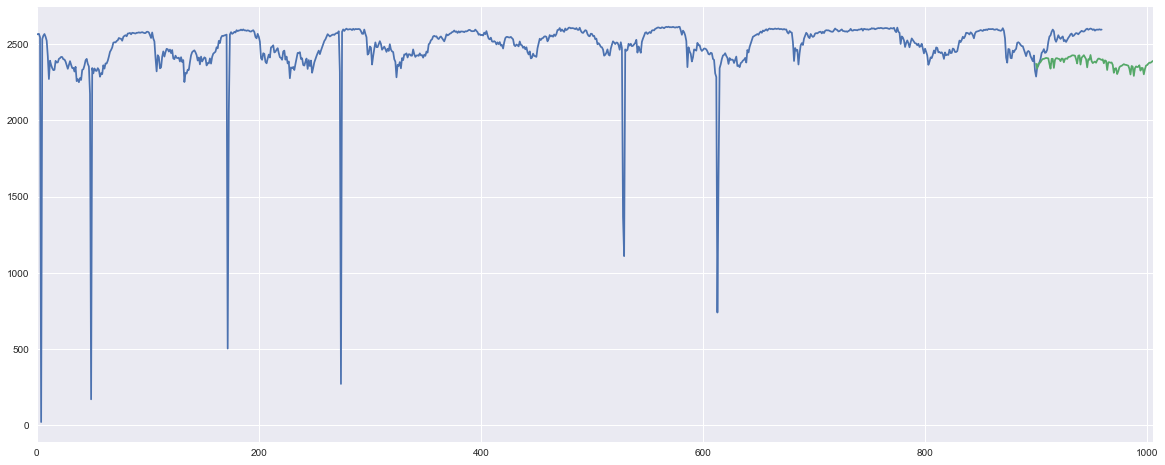

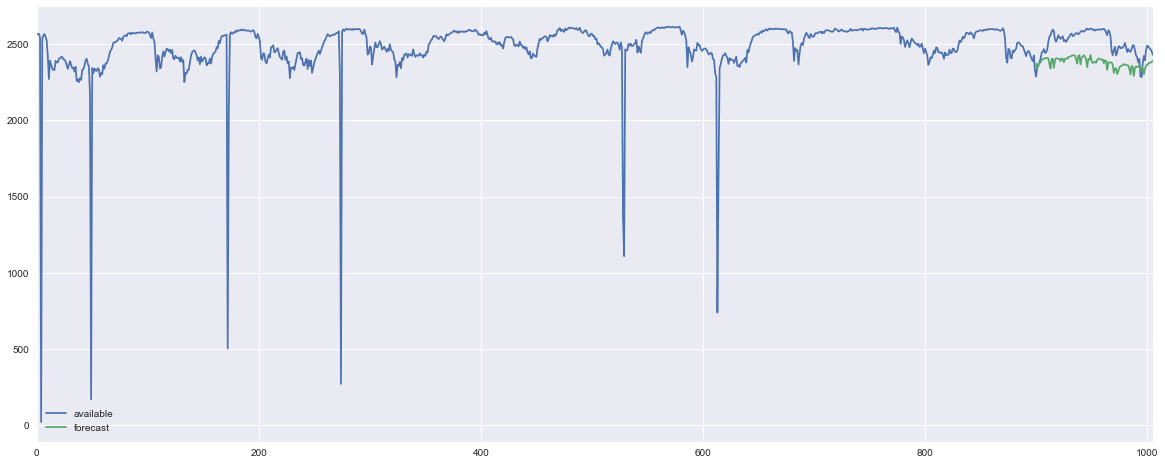

In [168]:
data['forecast'] = results.predict(start = 900, end= 1006, dynamic=True)
data.available.iloc[:960].plot()
data.forecast.plot(figsize=(20,8))
data[['available', 'forecast']].plot(figsize=(20, 8)) 
#plt.savefig('ts_df_predict.png', bbox_inches='tight')